Regresión:En el caso de los algoritmos de regresión, podemos decir que se trata de un subcampo del aprendizaje automático supervisado que tiene el fin de crear una metodología para relacionar un cierto número de características y una variable objetivo-continua.

Es decir lo que distinge la regresion de los clasificadores es que la variable objetivo se trata de un número que no expresa ningún atributo abstracto como puede ser el frio o el calor, sino que indica un valor numérico de temperatura.(siguiendo el ejemplo)

# Reconstrucción de números escritos a mano con MLPr (MultiLayer Perceptron Regression)

Libreria necesarias a importar y comprobación de disponibilidad de torch en nuestro dispositivo.

In [12]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


## Creación de los cargadores de datos.

1º Linea: Se define un tamaño de 128 datos de entrada al entrenar por iteración que forma el lote.

2º Linea: Se prepara la funcion trasnform para la normalizacion de los datos, es decir se extienden los datos dentro de un rango haciendo uso de la media y la desviación estandar de los datos de entrenamiento con el fin de mejorar el rendimiento de la red.

3º Linea:Se obtiene el conjunto de datos que forman el dataset de entrenamiento sin alterar, obtenido de MNIST aqui se aplica la normalización.

4º Linea:Se obtiene el conjunto de datos que forman el conjunto de validación, estos datos no se alteran por esos su parametro train esta a falso, ya que este conjunto nos servirá para comprobar la predicciones hechas por la red.

5º Linea:Se crea los datos de entrenamiento separado por lotes además a estos se les aplican una función shuffle que cambia de forma aleatoria la posición de estos dentro del conjunto (Esto sirve para que la red no se acomode a unos datos fijos y haga su predicción en base a la invariabilidad que no representan mundo real donde los eventos son cambiantes y desconocidos)

6º Linea:Se obtiene el conjunto de datos que forman el conjunto de validación del cargador, estos datos no se alteran por esos su parametro train esta a falso, ya que este conjunto nos servirá para comprobar la predicciones hechas por la red.

In [13]:
batch_size = 128

transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,)),
                                ])

train_dataset = datasets.MNIST('/tmp/data', 
                               train=True, 
                               download=True, 
                               transform=transforms)

validation_dataset = datasets.MNIST('/tmp/data', 
                                    train=False, 
                                    transform=transforms)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [14]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([128, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor


Mostramos los 10 primeros dígitos:

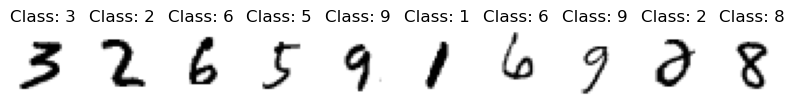

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## Definición del modelo MLP.

Este modelo tiene 3 capas: La primera con 50 neuronas, la segunda con 5, la tercera con 50 y la de salida con 784.
Función de activación Sigmoide excepto para la última que no tendrá ninguna.



In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 5)
        self.fc3 = nn.Linear(5, 50)
        self.fc4 = nn.Linear(50, 28*28)

    def forward(self, x):
        x = x.view(-1, 28*28) #pasamos al matriz a vector.
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return self.fc4(x)

## Creación del modelo, optimizador y función de pérdida.


1º Linea:Se define la red define la red.
2º Se elige el optimizador, en este caso Adam cuyos parámetros son los parametros del modelo y el learning rate.

El optimizador, es el encargado de generar pesos cada vez mejores: su importancia es crucial. Su funcionamiento esencial se basa en calcular el gradiente de la función de coste (derivada parcial) por cada peso (parametro/dimension) de la red. 

3º Se escoje el criterio de calculo de error, en este caso escoje obtener el error en funcion del error cuadrático      medio.


In [17]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=784, bias=True)
)


## Learning

Definición del método de entrenamiento `train()` y del método de validación `validate()`. 

Se inicia el proceso de entrenamiento poniendo el modelo en modo entrenamiento.

Se tiene un bucle que itera sobre los datos del lote, y se repite el siguiente proceso:

1º Se obtienen los datos.
2º Se limpia el gradiente para el entrenamiento.
3º Se pasan los datos de entrada por la red.
4º Se obtiene un vector de datos objetivo a partir de la matriz de datos original.
5º Se calcula el error de entrenamiento en funcion de los datos objetivo y la salida generada por lal red.
6º Se propagan los datos desde las capas mas profundas de la red hasta la primera, actualizando la "influencia" relativa de cada neurona sobre el resultado final a partir de los errores relativos(Linea 5) calculados tras la primera pasada de los datos iniciales por la red.
7º Se actualizan los pesos.


In [18]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, _) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # matriz a vector
        target = data.view(-1, 28*28)
        
        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

Se obtiene el error de entrenamiento medio para tener una visión general del rendimiento de la red

In [1]:
def validate(loss_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, _ in validation_loader:
        data = data.to(device)
        output = model(data)
        target = data.view(-1, 28*28)
        val_loss += criterion(output, target).data.item()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)
   
    print('\nValidation set: Average loss: {:.4f}.\n'.format(val_loss))


Se recontruyen los datos trasformados en vector a una matriz con el formato original del dataset orginial:
X_train: torch.Size([128, 1, 28, 28]) type: torch.FloatTensor

Y se ensambla con los datos de validación mediante la función hstack (los apila horizontalmente)

In [20]:
def get_reconstruction():
    model.eval()
    val_loss, correct = 0, 0
    for data, _ in validation_loader:
        data = data.to(device)
        output = model(data)
        output = output.reshape(128,1,28,28)
        mosaic = np.hstack((data[0].cpu().numpy().reshape(28,28), output[0].detach().cpu().numpy().reshape(28,28)))#[0]
        break
    return mosaic

# Bucle de entrenamiento

Por cada epoch, vamos a entrenar y después a validar el modelo. Finalmente en cada epoch, mostramos la imagen de reconstrucción

Método principal donde todo el proceso de entrenamiento se da lugar (donde se llaman a los métodos anteriormente descritos)

Se hace un bucle que itera por cada lote del dataset (data_loader) y se hacen los siguientes pasos:
1º Se entrena los datos.
2º Se valida el resultado.
3º Se reconstruyen los datos para tener una matriz con los datos listos para mostrar
4º Se muestra el resulatdo obtenido (el de la matriz)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.116545
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.686185
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.638025

Validation set: Average loss: 0.6318.



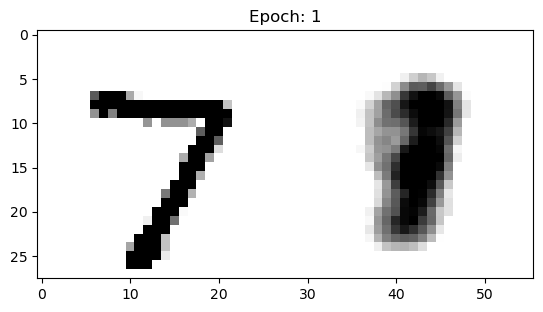

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.602143
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.621625
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.557476

Validation set: Average loss: 0.5665.



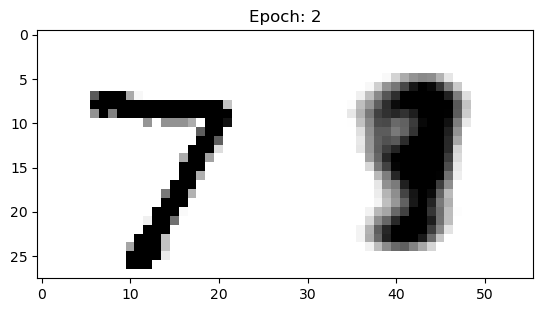

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.551718
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.535466
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.530637

Validation set: Average loss: 0.5195.



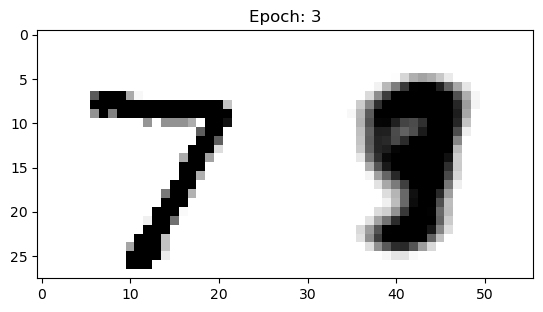

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.492427
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.501395
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.477214

Validation set: Average loss: 0.4896.



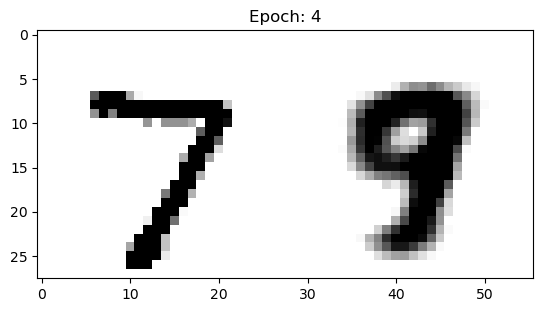

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.514912
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.469940
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.467266

Validation set: Average loss: 0.4740.



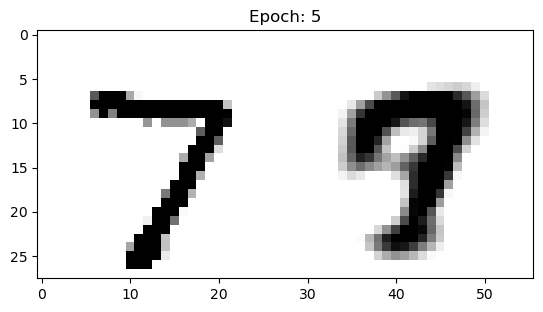

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.491545
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.460079
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.448386

Validation set: Average loss: 0.4699.



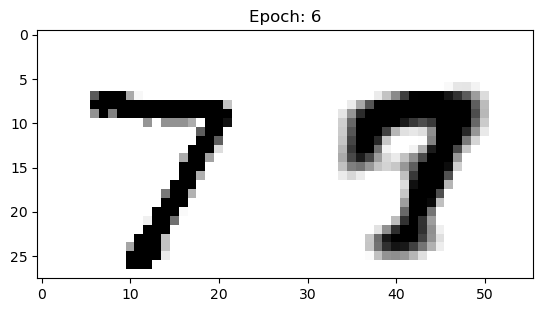

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.476605
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.459293
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.474799

Validation set: Average loss: 0.4671.



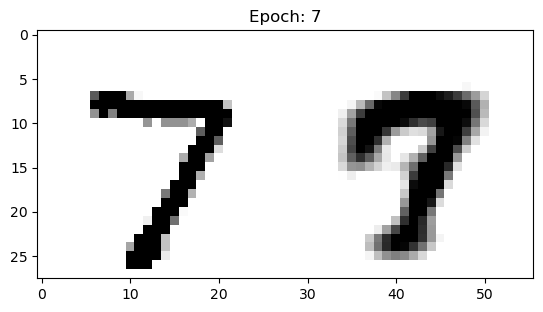

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.476411
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.475691
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.453065

Validation set: Average loss: 0.4634.



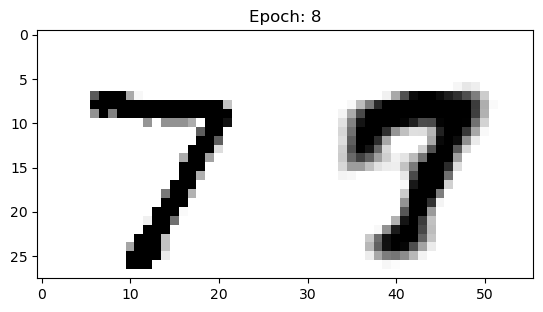

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.478500
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.480953
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.437488

Validation set: Average loss: 0.4567.



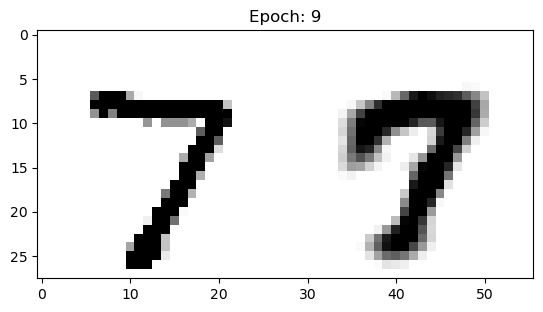

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.452533
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.460315
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.431051

Validation set: Average loss: 0.4480.



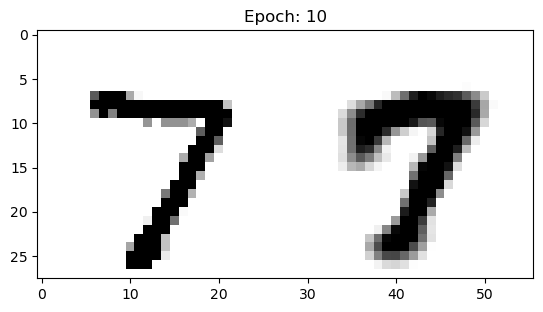

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.456818
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.446198
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.452907

Validation set: Average loss: 0.4379.



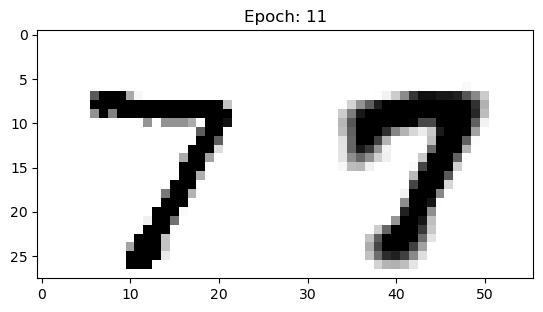

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.445772
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.441657
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.428717

Validation set: Average loss: 0.4281.



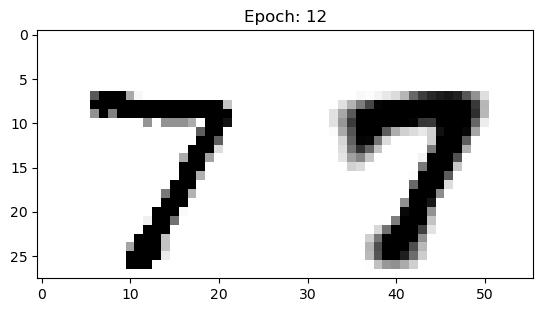

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.417611
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.437193
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.420071

Validation set: Average loss: 0.4202.



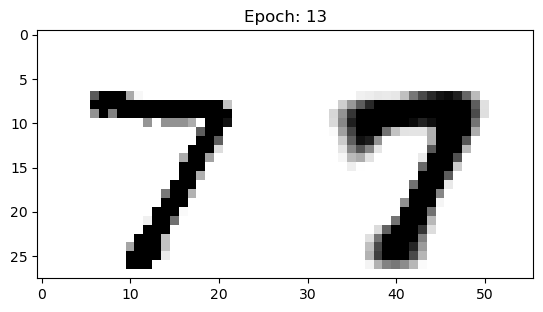

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.420601
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.423384
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.412527

Validation set: Average loss: 0.4142.



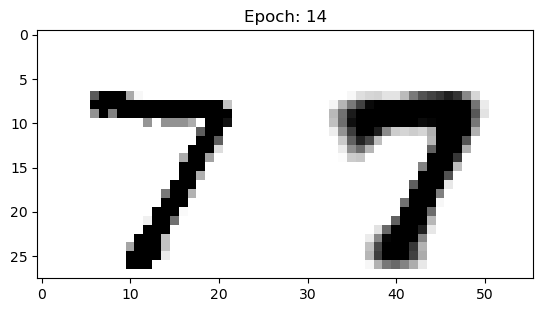

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.416368
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.410331
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.427048

Validation set: Average loss: 0.4091.



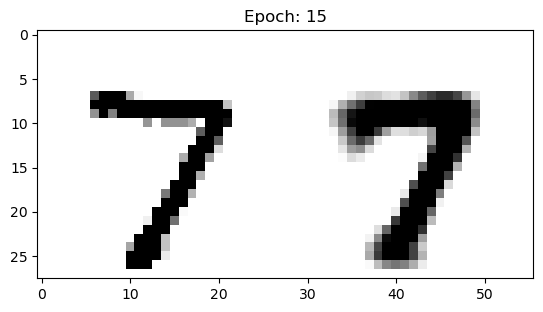

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.397460
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.422102
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.404253

Validation set: Average loss: 0.4053.



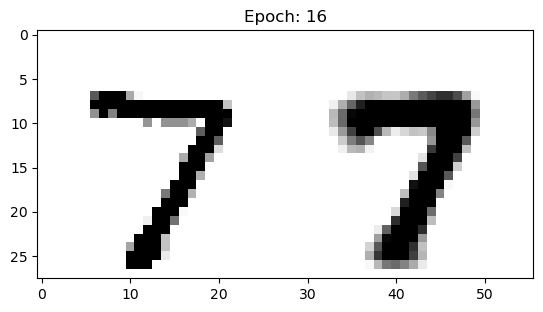

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.422068
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.419644
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.396348

Validation set: Average loss: 0.4015.



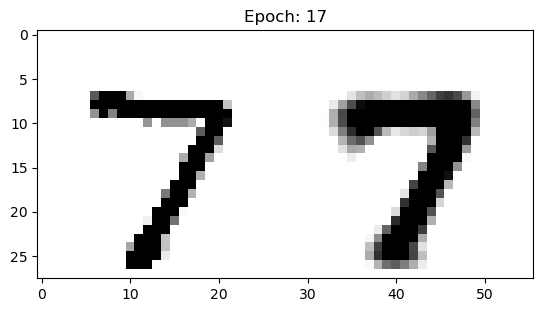

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.417539
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.382720
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.396593

Validation set: Average loss: 0.3987.



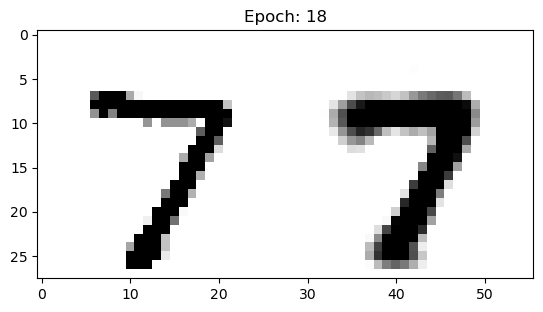

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.383921
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.423572
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.405917

Validation set: Average loss: 0.3954.



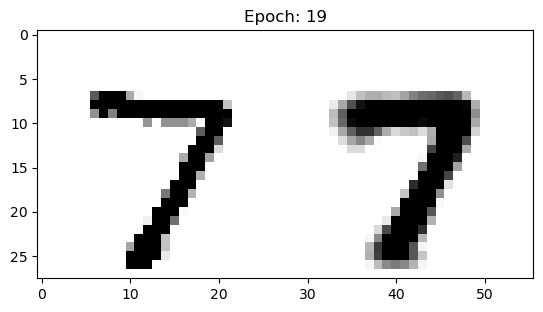

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.395642
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.394911
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.410020

Validation set: Average loss: 0.3927.



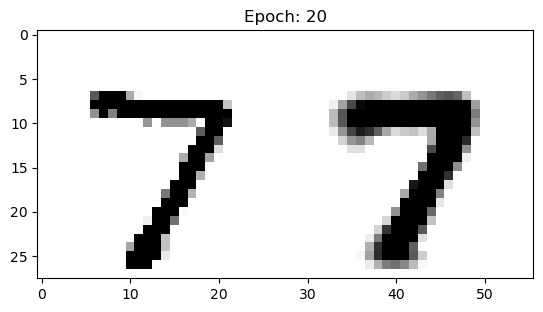

CPU times: user 3min 31s, sys: 390 ms, total: 3min 32s
Wall time: 3min 33s


In [21]:
%%time
epochs = 20

lossv = []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv)
    mosaic = get_reconstruction()
    plt.imshow(mosaic, cmap="gray_r", vmin=0, vmax=1)
    plt.title('Epoch: ' + str(epoch))
    plt.show()

Visualización del proceso de entrenamiento

* *Loss* diferencia entre la salida del modelo y la real.  Hay que minimizarla hasta 0, para ello usamos el optimizador.
* *Accuracy* es la precisión del modelo.

Se ha hecho una gráfica que muestra el error a lo largo de las iteraciones por lotes que se hacen, es decir como va progresando la red en su tarea (cada vez la red consigue un porcentaje de error mas pequeño).

Text(0.5, 1.0, 'validation loss')

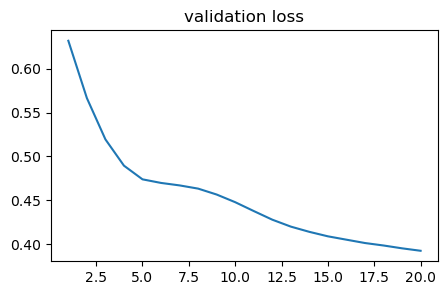

In [22]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
